In [77]:
import sys
sys.path.append('../')
import os

In [78]:
BASE_DIR = '../data/historical_klines/'

### ライブラリのインストール

In [103]:
import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### データの読み込み
＊データはダウンロードしておく必要がある

In [134]:
#パラメータの指定

symbols = [
    'ADA',
    'ASTR',
    'ATOM',
    'BAT',
    'BCH',
    'DAI',
    'DOT',
    'ENJ',
    'ETH',
    'FCR',
    'LINK',
    'LTC',
    'MKR',
    'MONA',
    'OMG',
    'QTUM',
    'XEM',
    'XLM',
    'XRP',
    'XTZ',
]
    
interval = '5min'

train_str_date = pd.to_datetime(datetime(2023,6,1))#.strftime('%Y%m%d')
train_end_date = pd.to_datetime(datetime(2023,6,10))#.strftime('%Y%m%d')

valid_str_date = pd.to_datetime(datetime(2023,6,11)).strftime('%Y%m%d')
valid_end_date = pd.to_datetime(datetime(2023,6,20)).strftime('%Y%m%d')

In [145]:
df = pd.DataFrame()

for symbol in symbols:
    for date in pd.date_range(start=train_str_date, end=valid_end_date):
        try:
            temp_df = pd.read_csv(f'{BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv')
            temp_df['symbol'] = symbol  # Add a new column to store symbol name
            df = pd.concat([df, temp_df], axis=0)
        except FileNotFoundError:
            print(f'File {BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv not found. Skipping...')


# Assuming df is your dataframe and 'openTime' is your column with the date
df['openTime'] = pd.to_datetime(df['openTime'], unit='ms')  # convert from UNIX timestamp, if necessary
df["datetime_f"] = df['openTime'] 
df["symbol_f"] = df['symbol']
# Convert 'symbol' and 'openTime' columns to index, creating a MultiIndex
df.set_index(['openTime', 'symbol'], inplace=True)


File ../data/historical_klines/5min/ADA/ADA_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/ADA/ADA_5min_20230620.csv not found. Skipping...
File ../data/historical_klines/5min/ASTR/ASTR_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/ASTR/ASTR_5min_20230620.csv not found. Skipping...
File ../data/historical_klines/5min/ATOM/ATOM_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/ATOM/ATOM_5min_20230620.csv not found. Skipping...
File ../data/historical_klines/5min/BAT/BAT_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/BAT/BAT_5min_20230620.csv not found. Skipping...
File ../data/historical_klines/5min/BCH/BCH_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/BCH/BCH_5min_20230620.csv not found. Skipping...
File ../data/historical_klines/5min/DAI/DAI_5min_20230619.csv not found. Skipping...
File ../data/historical_klines/5min/DAI/DAI_5min_20230620

In [146]:
df

,,open,high,low,close,volume,datetime_f,symbol_f
openTime,symbol,,,,,,,
2023-05-31 21:20:00,ADA,52.306,52.306,52.306,52.306,400.0,2023-05-31 21:20:00,ADA
2023-05-31 21:50:00,ADA,52.395,52.395,52.395,52.395,191.0,2023-05-31 21:50:00,ADA
2023-05-31 22:05:00,ADA,52.410,52.410,52.410,52.410,95.0,2023-05-31 22:05:00,ADA
2023-05-31 22:50:00,ADA,52.409,52.409,52.409,52.409,200.0,2023-05-31 22:50:00,ADA
2023-05-31 23:35:00,ADA,52.409,52.409,51.841,51.841,34.0,2023-05-31 23:35:00,ADA
...,...,...,...,...,...,...,...,...
2023-06-18 05:35:00,XTZ,103.464,103.572,103.464,103.572,550.0,2023-06-18 05:35:00,XTZ
2023-06-18 05:40:00,XTZ,102.978,102.978,102.978,102.978,1.0,2023-06-18 05:40:00,XTZ
2023-06-18 06:10:00,XTZ,103.146,103.170,103.146,103.170,0.2,2023-06-18 06:10:00,XTZ


In [147]:
train_df = df[(df.index.get_level_values('openTime') >= train_str_date) & (df.index.get_level_values('openTime') <= train_end_date)]
valid_df = df[(df.index.get_level_values('openTime') >= valid_str_date) & (df.index.get_level_values('openTime') <= valid_end_date)]

### テクニカル特徴量

In [148]:
def cal_technical_f(df):
    df = df.copy()
    #移動平均からの乖離率
    for i in [5, 20]:
        df[f"{i}sma_d_rate"] = df.groupby("symbol")["close"].transform(lambda x: x/(x.rolling(i).mean()) - 1)
    #直近のリターン
    df["past_1return"] = df.groupby("symbol")["close"].transform(lambda x: x/x.shift(1) - 1)
    #高値と安値の差額を終値で除した値
    df["h_l_by_c"] = (df["high"] - df["low"])/df["close"]
    #始値と終値の差を終値で除した値
    df["c_o_by_c"] = (df["close"] - df["open"])/df["close"]
    return df

### カテゴリ変数

In [149]:
def cal_category_f(df):
    df = df.copy()
    #日付情報を分割
    df["month"] = df["datetime_f"].dt.month
    df["day"] = df["datetime_f"].dt.day
    df["hour"] = df["datetime_f"].dt.hour
    df["week"] = df["datetime_f"].dt.dayofweek #曜日
    return df

### ターゲット

In [150]:
def cal_target(df):
    df.loc[:, "return"] = df.groupby("symbol")["close"].transform(lambda x: x.shift(-1)/x - 1)
    df.loc[:, "return_rank"] = df.groupby("openTime")["return"].transform(lambda x: x.rank(method = "min"))
    return df

### 分割したDataFrameごとに計算

In [151]:
train_df = cal_technical_f(train_df)
train_df = cal_category_f(train_df)
train_df = cal_target(train_df)

valid_df = cal_technical_f(valid_df)
valid_df = cal_category_f(valid_df)
valid_df = cal_target(valid_df)

### 特徴量とターゲットの指定

In [152]:
f_list = [
    #"open",
    #"close",
    #"high",
    #"low",
    "volume", #注文現物通貨量
    #"q_volume", #注文引用通貨量
    #"n_trades",
    #"taker_vol", #成行注文現物通貨量
    #"taker_q_vol", #成行注文引用通貨量
    #テクニカル特徴量
    "5sma_d_rate",
    "20sma_d_rate",
    #"75sma_d_rate",
    #"200sma_d_rate",
    "past_1return",
    "h_l_by_c",
    "c_o_by_c",
    #"taker_r",
    #"taker_q_r", 
    #"vol_by_trade",
    #カテゴリ変数
    "symbol_f",
    #"month",
    #"day",
    "hour",
    #"week",
]

target = "return_rank"

### ラベルエンコーディング

In [153]:
le = LabelEncoder()
train_df['symbol_f'] = le.fit_transform(train_df['symbol_f'])
valid_df['symbol_f'] = le.fit_transform(valid_df['symbol_f'])

### 学習

In [154]:
class LambdaRank_all:
    def __init__(self, df_train, df_valid, df_test, symbols_num, f_list, target):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.symbols_num = symbols_num
        self.f_list = f_list
        self.target = target
    
    def train(self):
        ranker = lgb.LGBMRanker(
            n_estimators=500,
            learning_rate=0.05,
            objective="lambdarank",
            label_gain=np.arange(200),
            # lambdarank_truncation_level=max_labels,
            # max_depth=5,
            # colsample_bytree=0.5,
            # num_leaves=2**6-1,
            n_jobs=-1
        )

        ranker.fit(
            X = self.df_train[self.f_list],
            y = self.df_train[self.target],
            group = self.df_train.groupby("datetime_f")["datetime_f"].count().to_numpy(),
            eval_set = [(self.df_valid[self.f_list], self.df_valid[self.target])],
            eval_group = [self.df_valid.groupby("datetime_f")["datetime_f"].count().to_numpy()],
        )

        lgb.plot_importance(ranker, figsize = (12,8))

        self.df_train.loc[:,"predict_value"] = ranker.predict(self.df_train[self.f_list]).copy()
        self.df_valid.loc[:,"predict_value"] = ranker.predict(self.df_valid[self.f_list]).copy()
        self.df_test.loc[:,"predict_value"] = ranker.predict(self.df_test[self.f_list]).copy()

        self.df_train["predict_rank"] = self.df_train.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_train.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()

        self.df_valid["predict_rank"] = self.df_valid.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_valid.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()

        self.df_test["predict_rank"] = self.df_test.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_test.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()




    def result(self, save_dir):


        df_short = self.df_train.loc[self.df_train["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_train.loc[self.df_train["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_train = df_long - df_short

        df_short = self.df_valid.loc[self.df_valid["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_valid.loc[self.df_valid["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_valid = df_long - df_short

        df_short = self.df_test.loc[self.df_test["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_test.loc[self.df_test["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_test = df_long - df_short

        # 時系列グラフを作成

        fig = plt.figure(figsize = (20,7))

        ax1 = fig.add_subplot(4, 1, 1)
        ax2 = fig.add_subplot(4, 1, 2)
        ax3 = fig.add_subplot(4, 1, 3)
        ax4 = fig.add_subplot(4, 1, 4)


        ax1.plot(pd.to_datetime(list(df_ls_train.index)), df_ls_train, label = "train")
        ax1.legend()
        ax1.set_xlabel('Date')
        ax1.set_ylabel('cumsum return')

        ax2.plot(pd.to_datetime(list(df_ls_valid.index)), df_ls_valid, label = "valid")
        ax2.legend()
        ax2.set_xlabel('Date')
        ax2.set_ylabel('cumsum return')

        ax3.plot(pd.to_datetime(list(df_ls_test.index)), df_ls_test, label = "test")
        ax3.legend()
        ax3.set_xlabel('Date')
        ax3.set_ylabel('cumsum return')

        ax4.text(0.05, 0.5, list(self.f_list))


        plt.savefig(save_dir) 
        plt.show()

[1]	valid_0's ndcg@1: 0.698623	valid_0's ndcg@2: 0.74479	valid_0's ndcg@3: 0.791965	valid_0's ndcg@4: 0.825876	valid_0's ndcg@5: 0.849023
[2]	valid_0's ndcg@1: 0.704591	valid_0's ndcg@2: 0.750771	valid_0's ndcg@3: 0.797606	valid_0's ndcg@4: 0.829442	valid_0's ndcg@5: 0.852336
[3]	valid_0's ndcg@1: 0.701137	valid_0's ndcg@2: 0.751983	valid_0's ndcg@3: 0.797591	valid_0's ndcg@4: 0.829528	valid_0's ndcg@5: 0.852309
[4]	valid_0's ndcg@1: 0.704707	valid_0's ndcg@2: 0.753503	valid_0's ndcg@3: 0.796892	valid_0's ndcg@4: 0.829992	valid_0's ndcg@5: 0.853382
[5]	valid_0's ndcg@1: 0.703304	valid_0's ndcg@2: 0.75479	valid_0's ndcg@3: 0.798629	valid_0's ndcg@4: 0.831183	valid_0's ndcg@5: 0.853846
[6]	valid_0's ndcg@1: 0.700089	valid_0's ndcg@2: 0.755638	valid_0's ndcg@3: 0.798519	valid_0's ndcg@4: 0.830692	valid_0's ndcg@5: 0.853057
[7]	valid_0's ndcg@1: 0.705623	valid_0's ndcg@2: 0.757761	valid_0's ndcg@3: 0.800518	valid_0's ndcg@4: 0.832164	valid_0's ndcg@5: 0.854431
[8]	valid_0's ndcg@1: 0.70599

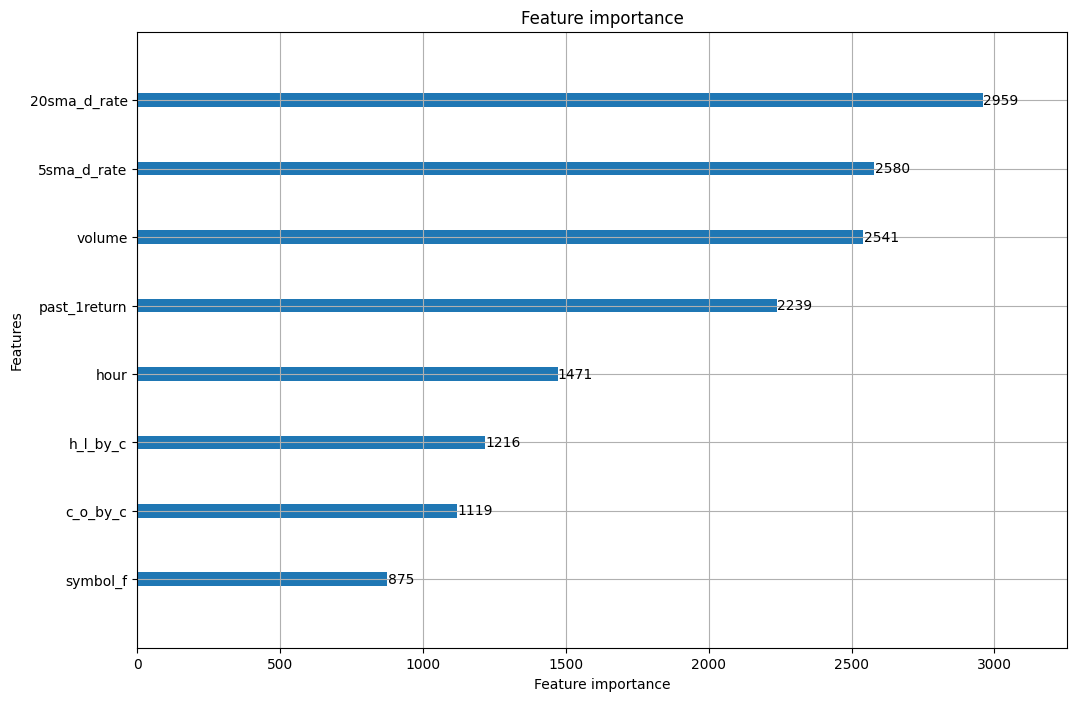

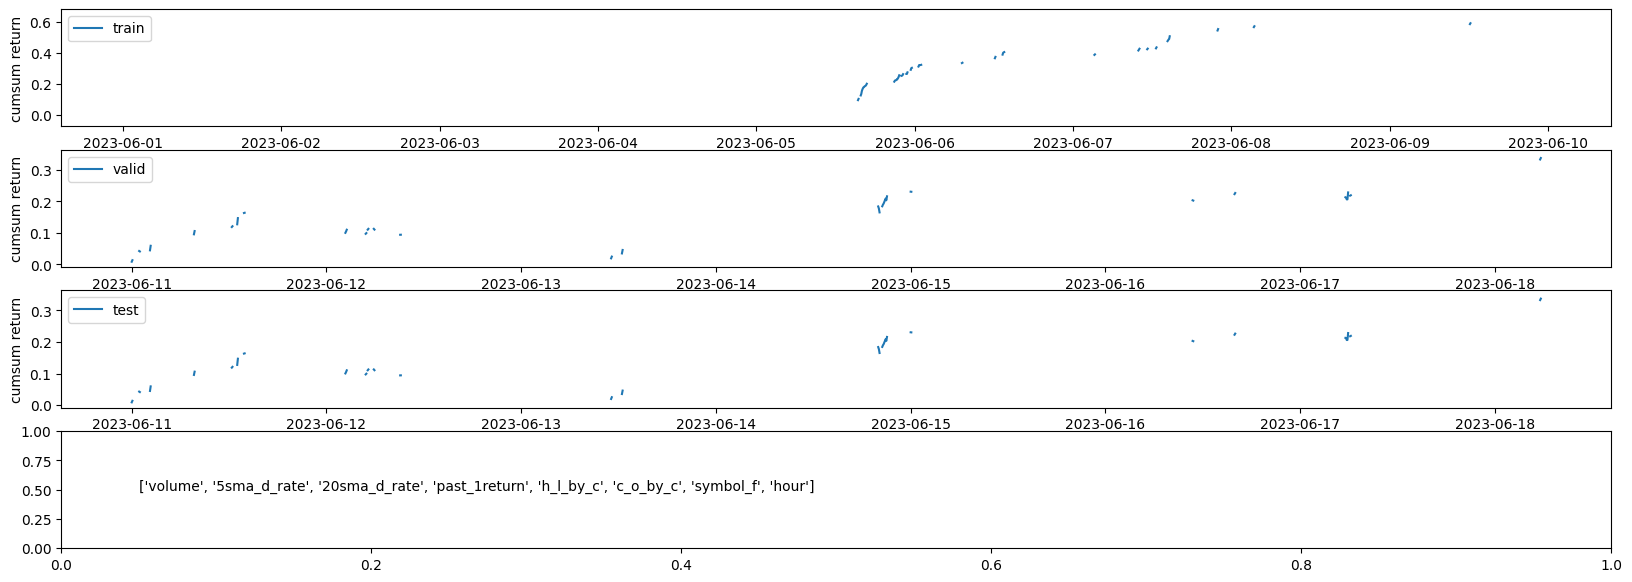

In [155]:
LTR_model = LambdaRank_all(train_df, valid_df, valid_df, len(symbols), f_list, target)
LTR_model.train()
LTR_model.result("./")

In [168]:
result = LTR_model.df_valid

*** データ数が十分にない場合，result["predict_rank"] > int(len(symbols)*0.3)　この条件を満たす銘柄が存在しない可能性がある

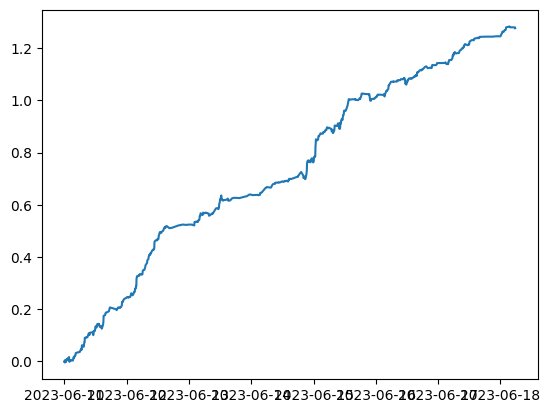

In [169]:
plt.plot(result.loc[result["predict_rank"] > int(len(symbols)*0.3)].groupby(level = "openTime")["return"].mean().cumsum())